Convert Json qua txt

In [ ]:
import os
import json
import shutil

old_folder = '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/0328'
new_folder = '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328'

image_folder = os.path.join(new_folder, 'images')
label_folder = os.path.join(new_folder, 'labels')
error_folder = os.path.join(new_folder, 'error_json')

os.makedirs(image_folder, exist_ok=True)
os.makedirs(label_folder, exist_ok=True)
os.makedirs(error_folder, exist_ok=True)

def convert_to_yolo_format(data, image_w, image_h):
    x_min, y_min = data['points'][0]
    x_max, y_max = data['points'][1]

    x_center = ((x_min + x_max) / 2) / image_w
    y_center = ((y_min + y_max) / 2) / image_h
    width = abs(x_max - x_min) / image_w
    height = abs(y_max - y_min) / image_h

    return x_center, y_center, width, height

def process_file(filename):
    json_path = os.path.join(old_folder, filename)

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Lấy tên ảnh chuẩn
        image_name = os.path.basename(data['imagePath'].replace('\\', '/'))
        image_path = os.path.join(old_folder, image_name)

        if not os.path.exists(image_path):
            print(f"[ERROR] Không tìm thấy ảnh: {image_name}")
            shutil.copy(json_path, os.path.join(error_folder, filename))
            return

        image_w, image_h = data['imageWidth'], data['imageHeight']
        label_path = os.path.join(label_folder, os.path.splitext(image_name)[0] + '.txt')

        shutil.copy(image_path, os.path.join(image_folder, image_name))

        with open(label_path, 'w', encoding='utf-8') as txt_file:
            for shape in data['shapes']:
                class_id = int(shape.get('label', 0))

                x_center, y_center, width, height = convert_to_yolo_format(shape, image_w, image_h)
                txt_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    except Exception as e:
        print(f"[ERROR] Lỗi xử lý {filename} : {e}")
        shutil.copy(json_path, os.path.join(error_folder, filename))

for filename in os.listdir(old_folder):
    if filename.endswith('.json'):
        process_file(filename)

print("✅ Hoàn tất tách folder và chuyển label chuẩn YOLO!")


Crop Plate

In [ ]:
import os
import cv2
import glob

image_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/images"
label_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/labels"
crop_output_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates"

os.makedirs(crop_output_dir, exist_ok=True)

image_files = glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.png"))

def crop_with_dynamic_padding(image, bbox, padding_ratio=0.1):
    h, w, _ = image.shape
    x_center, y_center, box_w, box_h = bbox

    x1 = int((x_center - box_w / 2) * w)
    y1 = int((y_center - box_h / 2) * h)
    x2 = int((x_center + box_w / 2) * w)
    y2 = int((y_center + box_h / 2) * h)

    pad_w = int(box_w * w * padding_ratio)
    pad_h = int(box_h * h * padding_ratio)

    x1 = max(0, x1 - pad_w)
    y1 = max(0, y1 - pad_h)
    x2 = min(w, x2 + pad_w)
    y2 = min(h, y2 + pad_h)

    return image[y1:y2, x1:x2], (x1, y1, x2, y2)

crop_count = 1  # Đếm thứ tự file crop

for image_path in image_files:
    label_path = os.path.join(label_dir, os.path.basename(image_path).replace(".jpg", ".txt").replace(".png", ".txt"))

    if not os.path.exists(label_path):
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    basename = os.path.splitext(os.path.basename(image_path))[0]

    with open(label_path, "r") as f:
        lines = f.readlines()

    print("-" * 50)
    print(f"📸 Ảnh gốc: {basename}.jpg (Size: {w}x{h})")

    plate_id = 0

    for line in lines:
        values = line.strip().split()
        class_id = int(values[0])
        bbox = list(map(float, values[1:]))

        if class_id == 3:
            cropped_img, (x1, y1, x2, y2) = crop_with_dynamic_padding(image, bbox, padding_ratio=0.1)

            crop_filename = f"crop_plate_{basename}_{plate_id}.jpg"
            crop_path = os.path.join(crop_output_dir, crop_filename)
            cv2.imwrite(crop_path, cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))

            label_filename = f"crop_plate_{basename}_{plate_id}.txt"
            label_path_new = os.path.join(crop_output_dir, label_filename)

            with open(label_path_new, "w") as f:
                f.write(line.strip() + "\n")

            print(f"🔲 Bounding Box gốc (YOLO format): {bbox}")
            print(f"🖼️ Ảnh crop: {crop_filename} (Saved at: {crop_path})")
            print(f"🔲 Vị trí crop (pixels): x1={x1}, y1={y1}, x2={x2}, y2={y2}")

            plate_id += 1
            crop_count += 1


Func các phương pháp au

In [2]:
import cv2
import numpy as np
import albumentations as A
import random
from PIL import Image, ImageEnhance


# Augment HÌNH HỌC (Hình dạng - Camera View)

# Xoay nhẹ ảnh (Rotate ±10 độ)
def augment_rotate(image):
    aug = A.Rotate(limit=10, p=1)
    return aug(image=image)['image']


# Xiên ảnh (Shear nhẹ)
def augment_shear(image):
    aug = A.Affine(shear={"x": random.uniform(-10, 10), "y": 0}, p=1)
    return aug(image=image)['image']


# Làm mờ nhẹ ảnh (Blur nhẹ)
def augment_blur(image):
    aug = A.GaussianBlur(blur_limit=(1, 2), p=1)
    return aug(image=image)['image']


# Thay đổi độ sáng & tương phản (Brightness + Contrast)
def augment_brightness_contrast(image):
    aug = A.RandomBrightnessContrast(p=1)
    return aug(image=image)['image']


# Thêm bóng đổ ngẫu nhiên (Shadow)
def augment_shadow(image):
    aug = A.RandomShadow(p=1)
    return aug(image=image)['image']


# Biến dạng góc nhìn nhẹ (Perspective)
def augment_perspective(image):
    aug = A.Perspective(scale=(0.05, 0.1), p=1)
    return aug(image=image)['image']


# Làm mòn biên (Erode)
def augment_erode(image):
    kernel = np.ones((2, 2), np.uint8)
    return cv2.erode(image, kernel, iterations=1)


# Làm to nét biên (Dilate)
def augment_dilate(image):
    kernel = np.ones((2, 2), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)


# Augment HIỆU ỨNG THỜI TIẾT (Weather Effect)

# Làm tối ảnh (Night)
def augment_night(image, darkness_level=0.5):
    pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Brightness(pil_img)
    darkened = enhancer.enhance(1.0 - darkness_level)
    return cv2.cvtColor(np.array(darkened), cv2.COLOR_RGB2BGR)


# Hiệu ứng mưa (Rain)
def augment_rain(image, rain_intensity=0.3):
    h, w, _ = image.shape
    rain_layer = np.zeros_like(image)
    num_drops = int(rain_intensity * w * h * 0.05)

    for _ in range(num_drops):
        x, y = random.randint(0, w-1), random.randint(0, h-1)
        length = random.randint(1, 5)
        angle = random.uniform(-np.pi/6, np.pi/6)
        if y + length < h:
            cv2.line(rain_layer, (x, y), (x + int(length * np.sin(angle)), y + length), (200, 200, 200), 1)

    rain_layer = cv2.GaussianBlur(rain_layer, (3, 3), 0)
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    return cv2.addWeighted(image, 0.8, blurred, 0.2, 0.0) + cv2.addWeighted(np.zeros_like(image), 0.85, rain_layer, 0.15, 0)


# Hiệu ứng sương mù (Fog)
def augment_fog(image, fog_intensity=0.5):
    fog = np.ones_like(image) * 255
    foggy = cv2.addWeighted(image, 1 - fog_intensity, fog, fog_intensity, 0)
    return cv2.GaussianBlur(foggy, (5, 5), 0)


# Hiệu ứng tuyết (Snow)
def augment_snow(image, snow_intensity=0.5):
    h, w, _ = image.shape
    snow_layer = np.zeros_like(image)
    num_flakes = int(snow_intensity * w * h * 0.01)

    for _ in range(num_flakes):
        x, y = random.randint(0, w-1), random.randint(0, h-1)
        size = random.randint(1, 3)
        cv2.circle(snow_layer, (x, y), size, (255, 255, 255), -1)

    brighter = cv2.addWeighted(image, 0.8, np.ones_like(image) * 50, 0.2, 0)
    return cv2.addWeighted(brighter, 0.8, snow_layer, 0.2, 0)


# Hiệu ứng lóa sáng (Glare)
def augment_glare(image, glare_intensity=0.3):
    h, w, _ = image.shape
    glare_layer = np.zeros_like(image)
    x, y = random.randint(w//4, 3*w//4), random.randint(h//4, 3*h//4)
    radius = int(min(w, h) * random.uniform(0.1, 0.3))
    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, (x, y), radius, 255, -1)
    mask = cv2.GaussianBlur(mask, (radius//2*2+1, radius//2*2+1), 0)
    alpha = mask.astype(float) / 255.0 * glare_intensity
    alpha = np.dstack([alpha, alpha, alpha])
    return (image * (1 - alpha) + np.ones_like(image) * 255 * alpha).astype(np.uint8)


# Hiệu ứng đèn xe ban đêm (Headlights)
def augment_headlights(image, intensity=0.7):
    h, w, _ = image.shape
    mask = np.zeros((h, w), np.uint8)
    pts1 = np.array([[int(w * 0.3), int(h * 0.8)], [int(w * 0.1), int(h * 0.2)], [int(w * 0.4), int(h * 0.2)]])
    pts2 = np.array([[int(w * 0.7), int(h * 0.8)], [int(w * 0.6), int(h * 0.2)], [int(w * 0.9), int(h * 0.2)]])
    cv2.fillPoly(mask, [pts1], 255)
    cv2.fillPoly(mask, [pts2], 255)
    mask = cv2.GaussianBlur(mask, (51, 51), 0)
    light_layer = np.zeros_like(image)
    light_layer[:] = (100, 220, 255)
    alpha = mask.astype(float) / 255.0 * intensity
    alpha = np.dstack([alpha, alpha, alpha])
    return (image * (1 - alpha) + light_layer * alpha).astype(np.uint8)


Ảnh gốc:


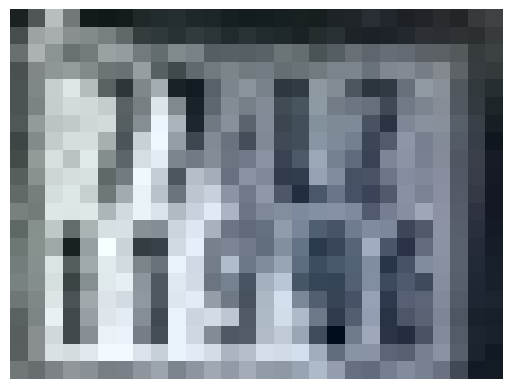

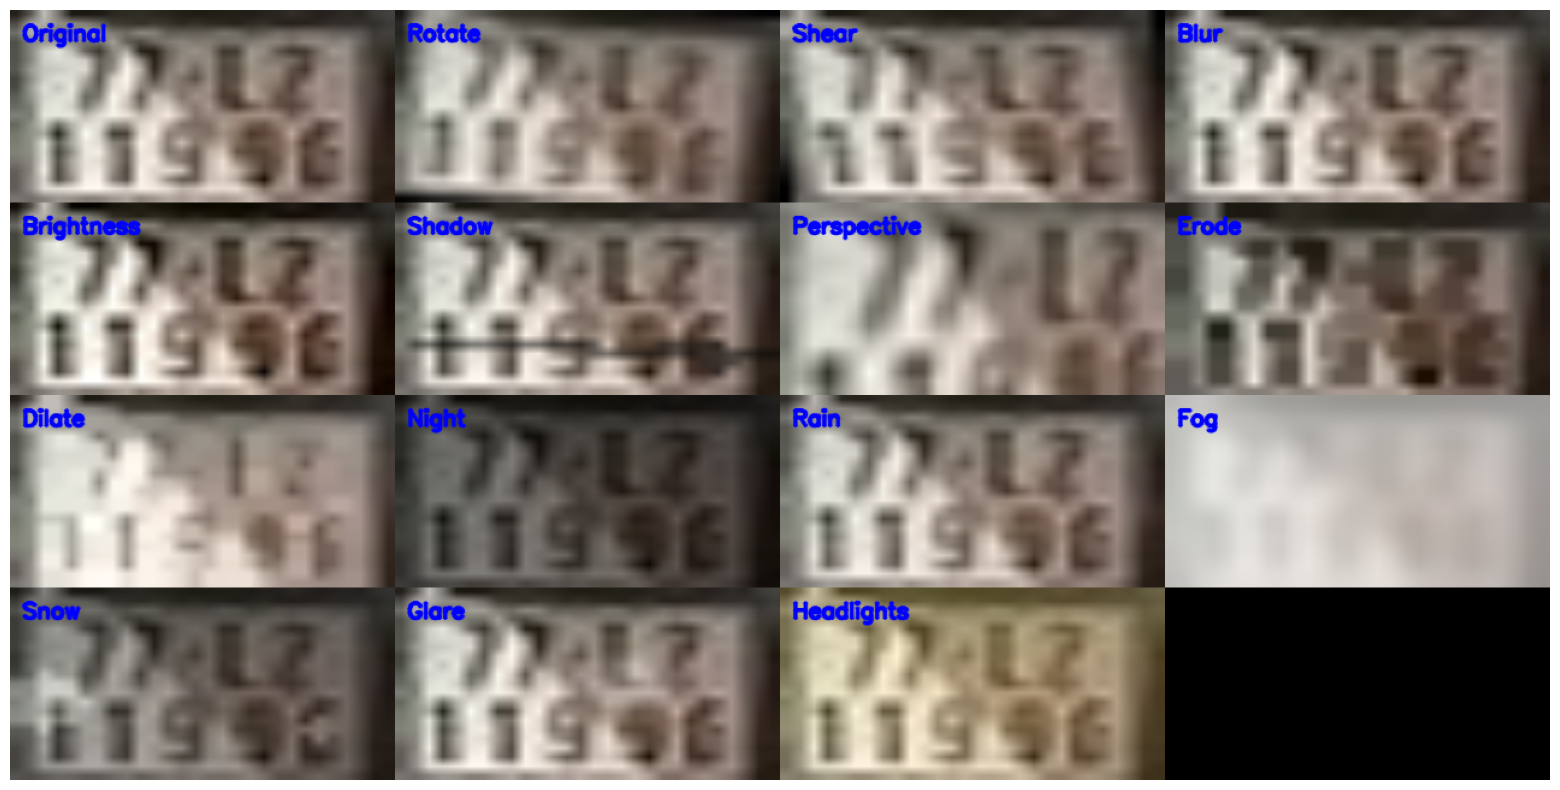

Lưu file grid tại: /content/augmented_grid_result.jpg


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def draw_text(img, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.6
    thickness = 2
    color = (255, 0, 0)
    img = img.copy()
    cv2.putText(img, text, (10, 25), font, scale, color, thickness, cv2.LINE_AA)
    return img


def visualize_augments(image):
    aug_methods = [
        ("Original", lambda img: img),
        ("Rotate", augment_rotate),
        ("Shear", augment_shear),
        ("Blur", augment_blur),
        ("Brightness", augment_brightness_contrast),
        ("Shadow", augment_shadow),
        ("Perspective", augment_perspective),
        ("Erode", augment_erode),
        ("Dilate", augment_dilate),
        ("Night", augment_night),
        ("Rain", augment_rain),
        ("Fog", augment_fog),
        ("Snow", augment_snow),
        ("Glare", augment_glare),
        ("Headlights", augment_headlights)
    ]

    images = []
    for name, func in aug_methods:
        aug_img = cv2.resize(func(image.copy()), (320, 160))
        aug_img = draw_text(aug_img, name)
        images.append(aug_img)

    return images


def display_grid(images, cols=4):
    rows = (len(images) + cols - 1) // cols
    grid = []

    for r in range(rows):
        row_imgs = images[r * cols:(r + 1) * cols]
        while len(row_imgs) < cols:
            row_imgs.append(np.zeros_like(row_imgs[0]))
        row = np.hstack(row_imgs)
        grid.append(row)

    grid_image = np.vstack(grid)

    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return grid_image


# Load ảnh thật
image_path = '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates/crop_plate_CAM013_20250326_0936_Nang_57_0.jpg'
image = cv2.imread(image_path)

if image is None:
    print(f"Lỗi load ảnh: {image_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print("Ảnh gốc:")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Apply all aug
    images = visualize_augments(image)

    # Show grid
    grid_image = display_grid(images)

    # Optional: Save file
    output_path = '/content/augmented_grid_result.jpg'
    cv2.imwrite(output_path, cv2.cvtColor(grid_image, cv2.COLOR_RGB2BGR))
    print(f"Lưu file grid tại: {output_path}")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import shutil
import numpy as np


augment_funcs = {
    "rotate": augment_rotate,
    "shear": augment_shear,
    "blur": augment_blur,
    "brightness": augment_brightness_contrast,
    "shadow": augment_shadow,
    "perspective": augment_perspective,
    "erode": augment_erode,
    "dilate": augment_dilate,
    "night": augment_night,
    "rain": augment_rain,
    "fog": augment_fog,
    "snow": augment_snow,
    "glare": augment_glare,
    "headlights": augment_headlights
}


def augment_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    img_ext = ['.jpg', '.jpeg', '.png']

    for file in os.listdir(input_folder):
        if os.path.splitext(file)[1].lower() not in img_ext:
            continue

        img_name = os.path.splitext(file)[0]
        img_path = os.path.join(input_folder, file)
        txt_path = os.path.join(input_folder, img_name + '.txt')

        image = cv2.imread(img_path)

        if image is None:
            print(f"[ERROR] Load failed: {file}")
            continue

        print(f"\n[PROCESSING] {file}")

        # Random 3 phương pháp khác nhau
        selected_augs = random.sample(list(augment_funcs.keys()), 2)

        for aug_name in selected_augs:
            aug_func = augment_funcs[aug_name]
            aug_image = aug_func(image.copy())

            new_img_name = f"{img_name}_{aug_name}.jpg"
            new_txt_name = f"{img_name}_{aug_name}.txt"

            img_output_path = os.path.join(output_folder, new_img_name)
            txt_output_path = os.path.join(output_folder, new_txt_name)

            # Save ảnh
            cv2.imwrite(img_output_path, aug_image)

            # Copy label txt
            if os.path.exists(txt_path):
                shutil.copy(txt_path, txt_output_path)

            print(f"    -> {aug_name} --> Saved: {new_img_name}")


# ----- RUN -----
input_folder = '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates'
output_folder = '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/output_aug_plate'

augment_folder(input_folder, output_folder)

print("\n[Done] All augment completed!")


In [3]:
import os
import cv2
import random
import shutil
import numpy as np

augment_funcs = {
    "rotate": augment_rotate,
    "shear": augment_shear,
    "blur": augment_blur,
    "brightness": augment_brightness_contrast,
    "shadow": augment_shadow,
    "perspective": augment_perspective,
    "erode": augment_erode,
    "dilate": augment_dilate,
    "night": augment_night,
    "rain": augment_rain,
    "fog": augment_fog,
    "snow": augment_snow,
    "glare": augment_glare,
    "headlights": augment_headlights
}

# ===== PATH =====
input_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/wrong_cases_images"
input_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/wrong_cases_labels.txt"
output_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_images"
output_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_labels.txt"
os.makedirs(output_img_dir, exist_ok=True)

# ===== READ LABEL FILE =====
label_map = {}
with open(input_label_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            label_map[parts[0]] = parts[1]

# ===== AUGMENT =====
with open(output_label_file, 'w', encoding='utf-8') as f_out:
    for img_name, gt_label in label_map.items():
        img_path = os.path.join(input_img_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"[❌] Lỗi đọc ảnh: {img_name}")
            continue

        # Chọn 2 augment random
        selected_augs = random.sample(list(augment_funcs.keys()), 2)

        for aug_name in selected_augs:
            aug_func = augment_funcs[aug_name]
            aug_img = aug_func(image.copy())

            new_img_name = f"{os.path.splitext(img_name)[0]}_{aug_name}.jpg"
            new_img_path = os.path.join(output_img_dir, new_img_name)

            cv2.imwrite(new_img_path, aug_img)
            f_out.write(f"{new_img_name}\t{gt_label}\n")
            print(f"[✅] {new_img_name} saved with label: {gt_label}")

print("\n[🎉] Augment hoàn tất! Đã lưu vào:")
print(f"- Ảnh: {output_img_dir}")
print(f"- Label: {output_label_file}")

[✅] crop_plate_1550_0_0_fog.jpg saved with label: 519.65
[✅] crop_plate_1550_0_0_glare.jpg saved with label: 519.65
[✅] HR532_images_1_1_shadow.jpg saved with label: 08170
[✅] HR532_images_1_1_dilate.jpg saved with label: 08170
[✅] crop_plate_217_1_2_glare.jpg saved with label: 52533
[✅] crop_plate_217_1_2_dilate.jpg saved with label: 52533
[✅] crop_plate_1381_0_3_rain.jpg saved with label: 193.82
[✅] crop_plate_1381_0_3_blur.jpg saved with label: 193.82
[✅] crop_plate_581_1_4_dilate.jpg saved with label: 74435
[✅] crop_plate_581_1_4_blur.jpg saved with label: 74435
[✅] crop_plate_1327_1_5_shadow.jpg saved with label: 450.24
[✅] crop_plate_1327_1_5_snow.jpg saved with label: 450.24
[✅] crop_plate_1394_1_6_shadow.jpg saved with label: 77-N1
[✅] crop_plate_1394_1_6_dilate.jpg saved with label: 77-N1
[✅] crop_plate_2069_1_7_snow.jpg saved with label: 104.39
[✅] crop_plate_2069_1_7_rotate.jpg saved with label: 104.39
[✅] HR140_images_1_8_blur.jpg saved with label: 474.88
[✅] HR140_images_1

In [4]:
import shutil

# ===== ĐƯỜNG DẪN =====
src_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/train_set"
dst_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_images"

src_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/rec_gt_train_new.txt"
dst_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_labels.txt"

# ===== 1. Copy toàn bộ ảnh từ train_set sang augmented_images =====
img_exts = ['.jpg', '.jpeg', '.png']
copied_count = 0

for file in os.listdir(src_img_dir):
    if os.path.splitext(file)[1].lower() in img_exts:
        src_path = os.path.join(src_img_dir, file)
        dst_path = os.path.join(dst_img_dir, file)
        shutil.copy(src_path, dst_path)
        copied_count += 1

print(f"✅ Đã copy {copied_count} ảnh từ {src_img_dir} → {dst_img_dir}")

# ===== 2. Gộp thêm nội dung label vào file augmented_labels.txt =====
with open(src_label_file, 'r', encoding='utf-8') as src_f:
    new_lines = src_f.readlines()

with open(dst_label_file, 'a', encoding='utf-8') as dst_f:
    dst_f.writelines(new_lines)

print(f"✅ Đã thêm {len(new_lines)} dòng label từ {src_label_file} vào {dst_label_file}")


✅ Đã copy 3208 ảnh từ /content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/train_set → /content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_images
✅ Đã thêm 3204 dòng label từ /content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/rec_gt_train_new.txt vào /content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_labels.txt


In [7]:
import os

# Đường dẫn
src_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/train_set"
src_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/rec_gt_train_new.txt"

# 1. Đếm số ảnh trong folder
img_exts = ['.jpg', '.jpeg', '.png']
img_files = [f for f in os.listdir(src_img_dir) if os.path.splitext(f)[1].lower() in img_exts]
total_images = len(img_files)

# 2. Đếm số dòng trong file label
with open(src_label_file, 'r', encoding='utf-8') as f:
    label_lines = [line.strip() for line in f if line.strip()]
total_labels = len(label_lines)

# Kết quả
print(f"📦 Tổng số ảnh trong folder: {total_images}")
print(f"📝 Tổng số dòng label: {total_labels}")


📦 Tổng số ảnh trong folder: 3208
📝 Tổng số dòng label: 3204


In [10]:
import os

# Đường dẫn
dst_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_images"
dst_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_labels.txt"

# 1. Lấy danh sách ảnh
img_exts = ['.jpg', '.jpeg', '.png']
image_files = [f for f in os.listdir(dst_img_dir) if os.path.splitext(f)[1].lower() in img_exts]
image_set = set(image_files)

# 2. Đọc danh sách label từ file
label_set = set()
with open(dst_label_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            label_set.add(parts[0])

# 3. Ảnh chưa có label
missing_labels = sorted(list(image_set - label_set))

# 4. In kết quả
print(f"📸 Tổng số ảnh: {len(image_set)}")
print(f"📝 Tổng số ảnh có label: {len(label_set & image_set)}")
print(f"❌ Số ảnh chưa có label: {len(missing_labels)}")

if missing_labels:
    print("\n🕵️  Danh sách ảnh thiếu label:")
    for img in missing_labels:
        print(f" - {img}")
else:
    print("🎉 Tất cả ảnh đều có label.")


📸 Tổng số ảnh: 3468
📝 Tổng số ảnh có label: 3468
❌ Số ảnh chưa có label: 0
🎉 Tất cả ảnh đều có label.


In [9]:
# Đường dẫn file label
dst_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/augmented_labels.txt"

# Danh sách label cần thêm
new_labels = [
    "HR365_images_0.jpg\t64 -B1",
    "HR415_images_0.jpg\t64 -T1",
    "HR541_images_0.jpg\t64 -D1",
    "HR578_images_0.jpg\t67 -H9"
]

# Ghi thêm vào file label
with open(dst_label_file, 'a', encoding='utf-8') as f:
    for line in new_labels:
        f.write(line.strip() + '\n')

print("✅ Đã thêm 4 dòng label vào file augmented_labels.txt")


✅ Đã thêm 4 dòng label vào file augmented_labels.txt


In [11]:
import os
import shutil

# ===== ĐƯỜNG DẪN GỐC =====
src_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/val_set"
src_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/rec_gt_val_fix.txt"

# ===== ĐƯỜNG DẪN ĐÍCH =====
dst_base_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec"
dst_img_dir = os.path.join(dst_base_dir, "val_set")
dst_label_file = os.path.join(dst_base_dir, "rec_gt_val_fix.txt")

# ===== 1. Tạo thư mục đích nếu chưa có =====
os.makedirs(dst_img_dir, exist_ok=True)

# ===== 2. Sao chép tất cả ảnh từ val_set =====
img_exts = ['.jpg', '.jpeg', '.png']
img_count = 0

for file in os.listdir(src_img_dir):
    if os.path.splitext(file)[1].lower() in img_exts:
        src_file = os.path.join(src_img_dir, file)
        dst_file = os.path.join(dst_img_dir, file)
        shutil.copy2(src_file, dst_file)
        img_count += 1

print(f"📸 Đã copy {img_count} ảnh vào thư mục: {dst_img_dir}")

# ===== 3. Copy file label =====
shutil.copy2(src_label_file, dst_label_file)
print(f"📝 Đã copy file label vào: {dst_label_file}")


📸 Đã copy 662 ảnh vào thư mục: /content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/val_set
📝 Đã copy file label vào: /content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/rec_gt_val_fix.txt
